In [1]:
#原始的数据路径
OriginDataDir = '../Data/OriginData'
CleanDataDir = '../Data/CleanData'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

In [3]:
for filename in os.listdir(OriginDataDir):
    print(filename)

credit_card_balance.csv
home_credit.png
previous_application.csv
POS_CASH_balance.csv
installments_payments.csv
bureau_balance.csv
ColExplanation.csv
HomeCredit_columns_description.csv
application_test.csv
sample_submission.csv
bureau.csv
application_train.csv


### 一些会用到的函数

In [4]:
def getDescOfColumns():
    # 获取每一列的描述文字
    # 加载已经做好的columns描述文件
    descPath = os.path.join(OriginDataDir, 'ColExplanation.csv')
    desc = pd.read_csv(descPath,index_col=0)
    return desc


def showPNGRelativeCSV():
    plt.figure(figsize=(20,20))
    PNGpath = os.path.join(OriginDataDir, 'home_credit.png')
    img = mpimg.imread(PNGpath)
    plt.imshow(img)
    plt.show()


def DescofCol(csvfile, colname):
    csvfilenew = csvfile.replace('train', '*')
    csvfilenew = csvfilenew.replace('test', '*')
    index = csvfilenew + colname
    return desc.loc[index][0]

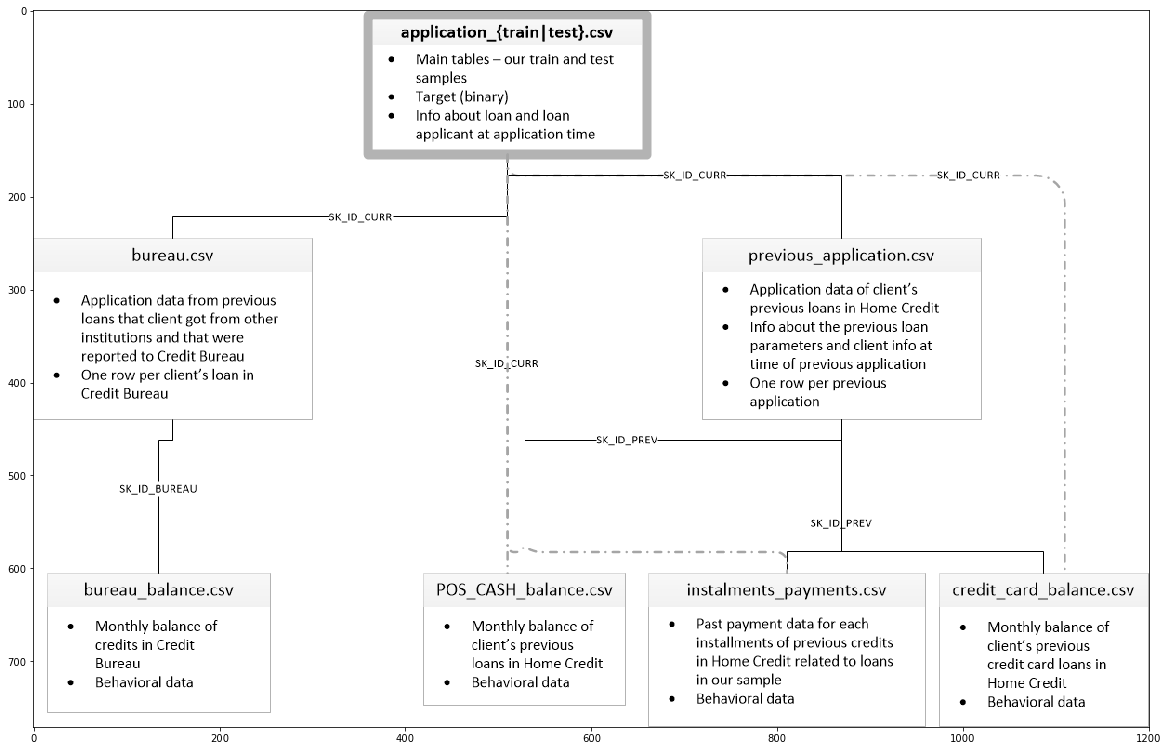

In [5]:
##看看保存下来的csv文件关系图
showPNGRelativeCSV()

In [6]:
### 加载保存好的columns描述
desc = getDescOfColumns()
desc.head()

,Description
application_*.csvSK_ID_CURR,ID of loan in our sample
application_*.csvTARGET,Target variable (1 - client with payment diffi...
application_*.csvNAME_CONTRACT_TYPE,Identification if loan is cash or revolving
application_*.csvCODE_GENDER,Gender of the client
application_*.csvFLAG_OWN_CAR,Flag if the client owns a car


## 第一次处理bureau_balance.csv

In [47]:
bureau_balance_path = os.path.join(OriginDataDir,'bureau_balance.csv')
df_buba = pd.read_csv(bureau_balance_path) 

In [48]:
df_buba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
SK_ID_BUREAU      int64
MONTHS_BALANCE    int64
STATUS            object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [49]:
df_buba.head(10)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [50]:
df_buba.SK_ID_BUREAU.nunique()

817395

In [51]:
DescofCol('bureau_balance.csv','MONTHS_BALANCE')

'Month of balance relative to application date (-1 means the freshest balance date)'

In [52]:
df_buba.MONTHS_BALANCE.count()/len(df_buba)#都没有缺省值,保留下来

1.0

In [53]:
df_buba.MONTHS_BALANCE.head(10)

0    0
1   -1
2   -2
3   -3
4   -4
5   -5
6   -6
7   -7
8   -8
9   -9
Name: MONTHS_BALANCE, dtype: int64

In [54]:
df_buba.MONTHS_BALANCE = abs(df_buba.MONTHS_BALANCE)#都变成正数

In [55]:
DescofCol('bureau_balance.csv','STATUS')

'Status of Credit Bureau loan during the month (active, closed, DPD0-30,\x85 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,\x85 5 means DPD 120+ or sold or written off ] )'

In [56]:
df_buba.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [57]:
def isDPD(s):
    if s=='C'or s=='0' or s=='X' or s=='1':
        return s
    else:
        return 'DPDmore1'

In [58]:
df_buba.STATUS = df_buba.STATUS.apply(isDPD)

In [59]:
df_buba.STATUS.value_counts()#DPD(days past due)

C           13646993
0            7499507
X            5810482
1             242347
DPDmore1      100596
Name: STATUS, dtype: int64

In [60]:
#类别不是很多都保留下来吧，做成onehot
df1 = pd.get_dummies(df_buba.STATUS,prefix='STATUS')

In [61]:
df_buba = pd.concat([df_buba,df1],axis=1)

In [62]:
df_buba.drop('STATUS',axis=1,inplace=True)

In [63]:
df_buba.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_C,STATUS_DPDmore1,STATUS_X
0,5715448,0,0,0,1,0,0
1,5715448,1,0,0,1,0,0
2,5715448,2,0,0,1,0,0
3,5715448,3,0,0,1,0,0
4,5715448,4,0,0,1,0,0


In [64]:
df_buba['MONTH_BALANCE_COUNT_BUREAU'] = 1

In [65]:
df_buba_tmp = df_buba.groupby('SK_ID_BUREAU')

In [66]:
## 	一个SK_ID_BUREAU	太多行了，做处理
MONTHS_BALANCE_max = df_buba_tmp['MONTHS_BALANCE'].agg('max')
MONTHS_BALANCE_max.head()

SK_ID_BUREAU
5001709    96
5001710    82
5001711     3
5001712    18
5001713    21
Name: MONTHS_BALANCE, dtype: int64

In [67]:
STATUS_SUM = df_buba_tmp[['STATUS_0','STATUS_1','STATUS_C','STATUS_X','STATUS_DPDmore1']].agg('sum')
STATUS_SUM.head()

,STATUS_0,STATUS_1,STATUS_C,STATUS_X,STATUS_DPDmore1
SK_ID_BUREAU,,,,,
5001709,0,0,86,11,0
5001710,5,0,48,30,0
5001711,3,0,0,1,0
5001712,10,0,9,0,0
5001713,0,0,0,22,0


In [68]:
STATUS_SUM = STATUS_SUM.div(STATUS_SUM.sum(axis=1),axis=0)

In [69]:
MONTHS_BALANCE_COUNT = df_buba_tmp['MONTH_BALANCE_COUNT_BUREAU'].agg('sum')
MONTHS_BALANCE_COUNT.head()

SK_ID_BUREAU
5001709    97
5001710    83
5001711     4
5001712    19
5001713    22
Name: MONTH_BALANCE_COUNT_BUREAU, dtype: int64

In [70]:
df_buba = pd.concat([MONTHS_BALANCE_COUNT,MONTHS_BALANCE_max,STATUS_SUM],axis=1)
df_buba.reset_index(inplace=True)

In [71]:
df_buba.rename(columns={'MONTHS_BALANCE':'MONTHS_BALANCE_BUREAU_max'},inplace=True)

In [73]:
df_buba.head()

,SK_ID_BUREAU,MONTH_BALANCE_COUNT_BUREAU,MONTHS_BALANCE_BUREAU_max,STATUS_0,STATUS_1,STATUS_C,STATUS_X,STATUS_DPDmore1
0,5001709,97,96,0.000000,0.0,0.886598,0.113402,0.0
1,5001710,83,82,0.060241,0.0,0.578313,0.361446,0.0
2,5001711,4,3,0.750000,0.0,0.000000,0.250000,0.0
3,5001712,19,18,0.526316,0.0,0.473684,0.000000,0.0
4,5001713,22,21,0.000000,0.0,0.000000,1.000000,0.0


In [43]:
print(sum(df_buba.MONTH_BALANCE_COUNT_BUREAU == df_buba.MONTHS_BALANCE_BUREAU_max+1))
print(sum(df_buba.MONTH_BALANCE_COUNT_BUREAU != df_buba.MONTHS_BALANCE_BUREAU_max+1))

610965
206430


In [44]:
#这个可以作为一个特征
df_buba['EqualCountMaxMonth_bureau'] = df_buba.MONTH_BALANCE_COUNT_BUREAU == df_buba.MONTHS_BALANCE_BUREAU_max+1
df_buba['EqualCountMaxMonth_bureau'] = df_buba['EqualCountMaxMonth_bureau'].astype(int)

In [60]:
##先保存起来
df_buba.to_csv(os.path.join(CleanDataDir,'bureau_balance_c1.csv'))

In [61]:
df_buba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817395 entries, 0 to 817394
Data columns (total 7 columns):
SK_ID_BUREAU                  817395 non-null int64
MONTH_BALANCE_COUNT_BUREAU    817395 non-null int64
MONTHS_BALANCE                817395 non-null int64
STATUS_0                      817395 non-null float64
STATUS_C                      817395 non-null float64
STATUS_X                      817395 non-null float64
STATUS_DPD                    817395 non-null float64
dtypes: float64(4), int64(3)
memory usage: 43.7 MB
